# Paso 1. Carga y exploracion del dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
games = pd.read_csv('/datasets/games.csv')

In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


# Paso 2. Preparar los datos

In [5]:
# Reemplazo los nombres de las columnas a minusculas
games.columns = games.columns.str.lower()

In [6]:
# Elimino los juegos que no tienen año de lanzamiento
games = games.dropna(subset = ['year_of_release'])

# Reemplazo los 'tbd' por valores NaN
games['user_score'].replace('tbd', np.nan, inplace = True)

In [7]:
# Convierto la columna 'year_of_release' a tipo 'int'
games['year_of_release'] = games['year_of_release'].astype('int')

# Convierto la columna 'user_score' a tipo numerico
games['user_score'] = games['user_score'].astype('float')

In [8]:
# Calculo las ventas totales
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

1. Valores ausentes en 'year_of_release'
    - Decidi eliminar los juegos que no tienen año de lanzamiento ya que no podemos analizar un juego sin saber cuando fue lanzado
2. Valores ausentes en `user_score`, `critic_score`, `rating`
    - Eleji dejarlos en blanco por ahora
    - Un juego sin score puede significar que se lanzó recientemente, fue poco conocido o que el valor simplemente se perdió
3. Los `tbd`:
    - Reemplace los `tbd` por valores `NaN`, reemplazarlos por $0$ nos indicaria una calificacion negativa por parte de los usuarios, en cambio, un valor ausente no afectaria las conclusiones finales. 
4. Cambio de tipos:
    - Se cambiaron `year_of_release` a 'int' y `user_score` a float para que los cálculos  funcionen, ya que los NaN son flotantes

# Paso 3. Analisis de Datos

## 3.1 Mira cuántos juegos fueron lanzados en diferentes años. ¿Son significativos los datos de cada período?

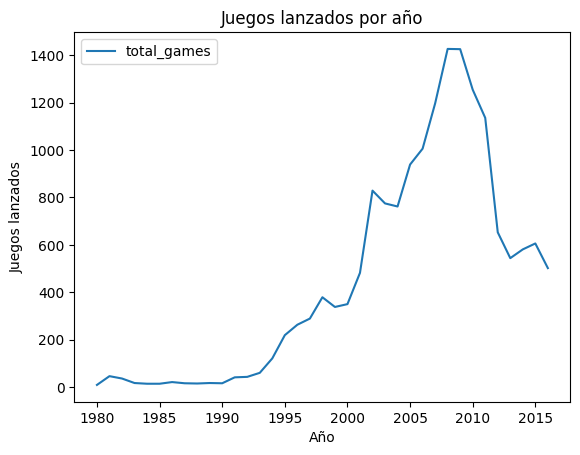

In [9]:
# Juegos lanzados por año
games_by_year = games.groupby('year_of_release')['name'].count().rename('total_games')

# Convierto el series en DataFrame
games_by_year = games_by_year.reset_index()

# Creo una grafica de barras para visualizar mejor los datos
games_by_year.plot(kind = 'line', x = 'year_of_release', y = 'total_games')
plt.title('Juegos lanzados por año')
plt.xlabel('Año')
plt.ylabel('Juegos lanzados')
plt.show()

## 3.2 Observa cómo varían las ventas de una plataforma a otra.

In [10]:
# Ventas por plataforma
total_sales_by_platform = games.groupby('platform')['total_sales'].sum()

# Ordeno de manera descendente
total_sales_by_platform = total_sales_by_platform.sort_values(ascending = False)

## 3.2.1 Elige las plataformas con las mayores ventas totales y construye una distribución basada en los datos de cada año. Busca las plataformas que solían ser populares pero que ahora no tienen ventas.

In [11]:
# Top 10 plataformas
total_sales_by_platform.head(10)

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
Name: total_sales, dtype: float64

In [12]:
# Filtro el DataFrame 'games' para quedarme unicamente con la info de las top 5 plataformas
top_10 = total_sales_by_platform.head(10).index
top_10_platforms = games[games['platform'].isin(top_10)]

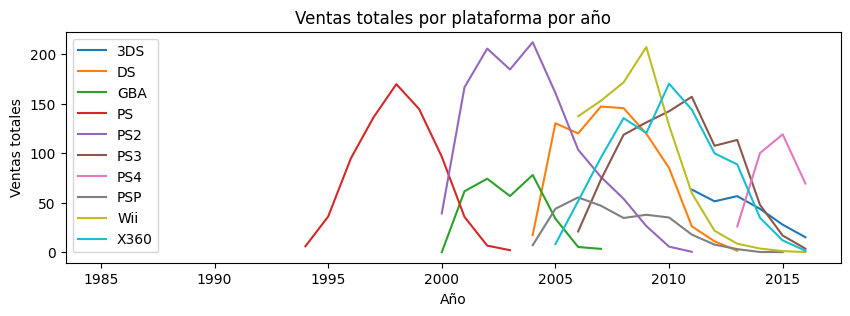

In [13]:
# Ventas por plataforma y año
top_10_platforms_sales = top_10_platforms.groupby(['platform', 'year_of_release'])['total_sales'].sum()

# Convierto en DataFrame
top_10_platforms_sales = top_10_platforms_sales.reset_index()

# Hago un pivot_table() para graficar
top_10_platforms_sales = top_10_platforms_sales.pivot_table(
    index = 'year_of_release',
    columns = 'platform',
    values = 'total_sales'
)

# Creo un grafico de linea
top_10_platforms_sales.plot(kind = 'line', figsize = (10, 3), legend = False)
plt.title('Ventas totales por plataforma por año')
plt.xlabel('Año')
plt.ylabel('Ventas totales')
plt.legend()
plt.show()

## 3.2.2 ¿Cuánto tardan generalmente las nuevas plataformas en aparecer y las antiguas en desaparecer?
Las plataformas suelen tener una vida util de 10 años aproximademente, por lo que si queremos pronosticar ventas del año 2017 tomaria como punto de partida el año 2007. De esta manera podremos analizar el comportamiento de las plataformas activas y de nuevas generaciones.

In [14]:
# Filtro los juegos para quedarme unicamente con los juegos lanzados en 2007 en adelante
recent_games = games[games['year_of_release'] >= 2007]

## 3.3 ¿Qué plataformas son líderes en ventas?

In [15]:
# Busco las platafromas lideres del mercado entre 2007 y 2016
head_platforms = recent_games.groupby('platform')['total_sales'].sum()

# Ordeno de forma descendente
head_platforms = head_platforms.sort_values(ascending = False)

# Top 10
head_platforms.head(10)

platform
PS3     910.38
X360    901.37
Wii     754.03
DS      535.54
PS4     314.14
3DS     257.81
PSP     183.31
PS2     162.38
PC      160.57
XOne    159.32
Name: total_sales, dtype: float64

In [16]:
# Me quedo unicamente con la informacion de las top 5
top_10 = head_platforms.head(10).index
recent_head_platforms = recent_games[recent_games['platform'].isin(top_10)]
recent_head_platforms.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
13,Wii Fit,Wii,2007,Sports,8.92,8.03,3.60,2.15,80.0,7.7,E,22.70
14,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61.0,6.3,E,21.82


## 3.3.1 ¿Cuáles crecen y cuáles se reducen?

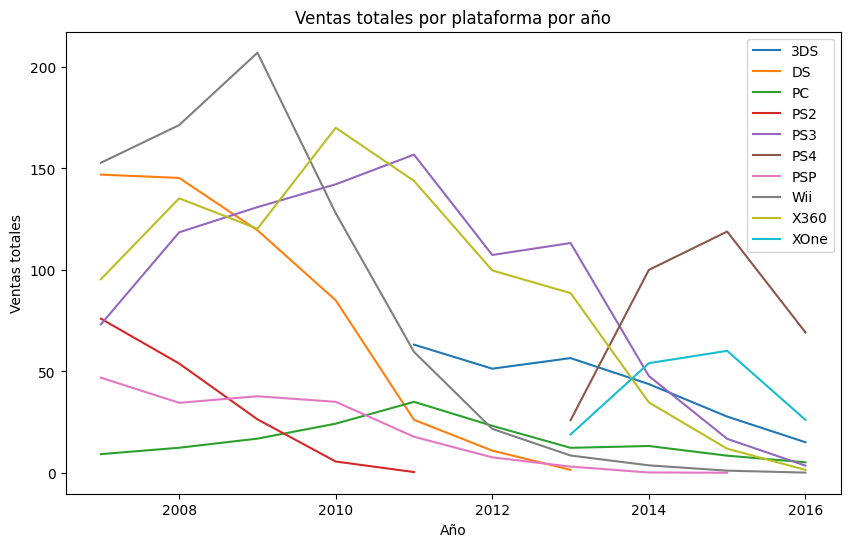

In [17]:
# Creo un grafico de lineas con las ventas por año para analizar cuáles crecen y cuáles se reducen del top 5.
recent_head_platforms = recent_head_platforms.pivot_table(
    index = 'year_of_release',
    columns = 'platform',
    values = 'total_sales',
    aggfunc = 'sum'
)

# Creo un grafico de linea
recent_head_platforms.plot(kind = 'line', figsize = (10, 6), legend = False)
plt.title('Ventas totales por plataforma por año')
plt.xlabel('Año')
plt.ylabel('Ventas totales')
plt.legend()
plt.show()

## Plataformas en fase de obsolescencia
Las plataformas `Wii`, `X360` y `PS3` muestran una clara tendencia a la baja y terminan cerca de 0 o con ventas muy bajas en 2016.

## Plataformas con potencial de crecimiento
`PS4` y `XOne` muestran una tendencia al alza. Mientras tanto la plataforma `PC` sus ventas se han mantenido estables con el paso del tiempo mostrando una permanencia en el mercado.

## 3.4 Crea un diagrama de caja para las ventas globales de todos los juegos, desglosados por plataforma.

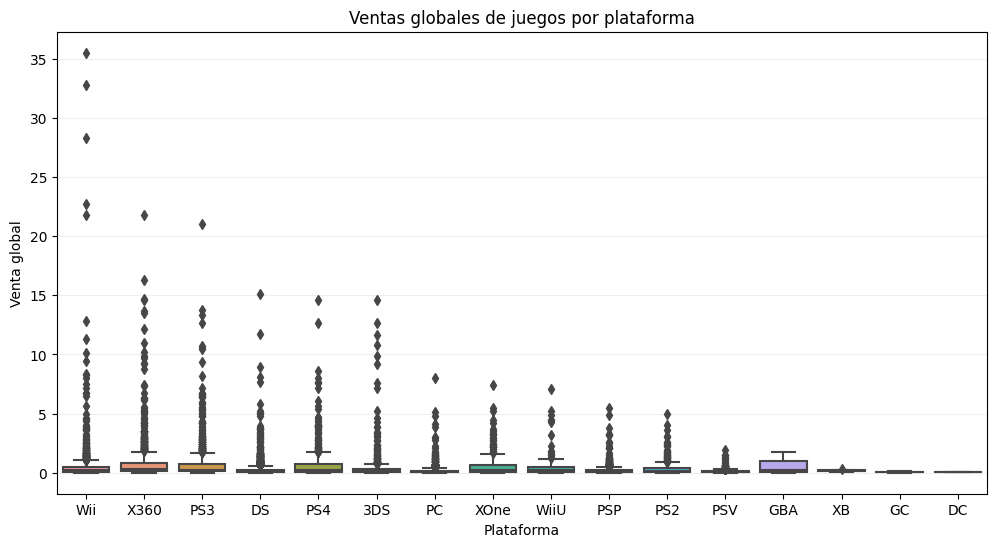

In [18]:
plt.figure(figsize = (12, 6))
sns.boxplot(
    x = 'platform',
    y = 'total_sales',
    data = recent_games
)


# Personalizo el diagrama
plt.title('Ventas globales de juegos por plataforma')
plt.xlabel('Plataforma')
plt.ylabel('Venta global')
plt.grid(axis = 'y', alpha = 0.2)
plt.show()


### 3.4.1 ¿Son significativas las diferencias en las ventas? ¿Qué sucede con las ventas promedio en varias plataformas? Describe tus hallazgos.

### La Mediana
La mediana de todas las plataformas es muy baja, casi en 0, lo que nos da a entender que la gran mayoria de los juegos lanzados en cualquier plataforma tienen ventas kuy bajas. El juego promedio no es un exito.

### Valores Atípicos
Los valores atípicos son los juegos blockbuster. Si bien el juego promedio vende poco, `Wii`, `X360` y `PS3` tuvieron el potencial de generar los mayores éxitos.

## 3.5 Mira cómo las reseñas de usuarios y profesionales afectan las ventas de una plataforma popular (tu elección).

Basado en el análisis de tendencia y el potencial, elegire la `PS4` como plataforma con potencial para el pronóstico de 2017 ya que muestra una tendencia al alza y alto potencial de outliers.

### 3.5.1 Crea un gráfico de dispersión y calcula la correlación entre las reseñas y las ventas

In [19]:
# Aislo solo la informacion de la PS4
ps4_data = recent_games[recent_games['platform'] == 'PS4']

### Relacion ventas vs puntuacion del critico

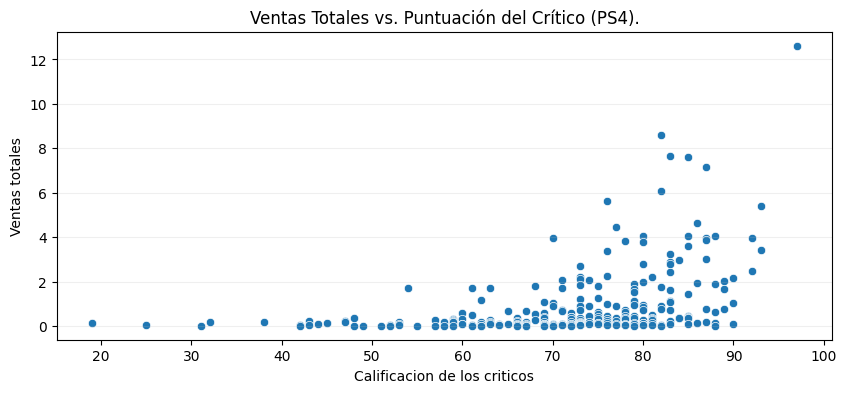

In [20]:
# Creo el grafico para la relacion
plt.figure(figsize = (10, 4))
sns.scatterplot(
    x = 'critic_score',
    y = 'total_sales',
    data = ps4_data
)

# Personalizo el grafico
plt.title('Ventas Totales vs. Puntuación del Crítico (PS4).')
plt.xlabel('Calificacion de los criticos')
plt.ylabel('Ventas totales')
plt.grid(axis = 'y', alpha = 0.2)
plt.show()

In [21]:
corr_critic = ps4_data['total_sales'].corr(ps4_data['critic_score'])
print(f"Coeficiente de correlacion (Ventas vs Critic Score): {corr_critic}")

Coeficiente de correlacion (Ventas vs Critic Score): 0.406567902061781


### Relacion ventas vs puntuacion del usuario

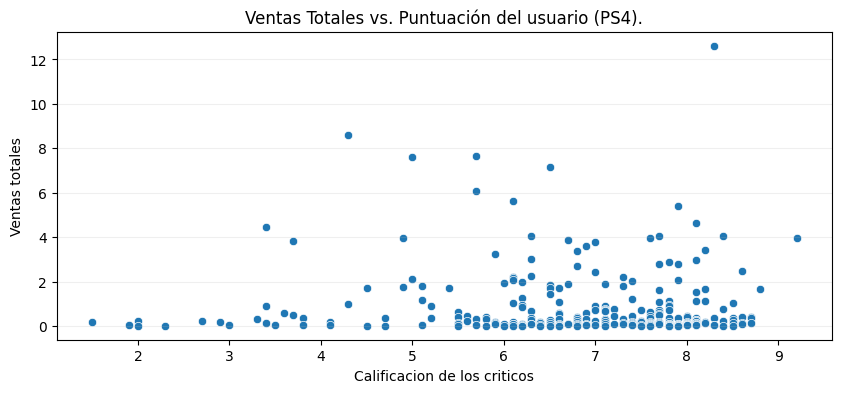

In [22]:
# Creo el grafico
plt.figure(figsize = (10, 4))
sns.scatterplot(
    x = 'user_score',
    y = 'total_sales',
    data = ps4_data
)

# Personalizo el grafico
plt.title('Ventas Totales vs. Puntuación del usuario (PS4).')
plt.xlabel('Calificacion de los criticos')
plt.ylabel('Ventas totales')
plt.grid(axis = 'y', alpha = 0.2)
plt.show()

In [23]:
corr_user = ps4_data['total_sales'].corr(ps4_data['user_score'])
print(f"Coeficiente de correlacion (Ventas vs User Score): {corr_user}")

Coeficiente de correlacion (Ventas vs User Score): -0.031957110204556376


## 3.5.2 Conclusiones


### Correlacion de Critico (0.406)
El coeficiente de correlacion 0.406 es positivo, muestra una relación moderada pero significativa. Los críticos sí parecen influir en las ventas iniciales de PS4. en el grafico podemos notar un patron en ascenso hacia la derecha.

### Correlacion de Usuario (-0.031)
El coeficiente de correlacion -0.031 es cercano a 0, una relación casi nula. La puntuacion del usuario (que puede llegar después de la compra) no tiene un relacion fuerte con las ventas totales. El grafico no muestra ningun patron, los puntos estan mas dispersos.

Para la `PS4` la reseña del critico es la que tiene mas impacto en el exito de las ventas


## 3.6 Teniendo en cuenta tus conclusiones compara las ventas de los mismos juegos en otras plataformas.

In [24]:
# Primero agrupare los juegos para encontrar los que son multiplataforma
multiplatform_games = recent_games.groupby('name')['platform'].nunique()

# Filtro los juegos que han sido publicados en mas de 1 plataforma
multiplatform_games = multiplatform_games[multiplatform_games > 1]

In [25]:
# Aislo la data de los juegos multiplataforma
multiplatform_games = multiplatform_games.index

multiplatform_games_data = recent_games[recent_games['name'].isin(multiplatform_games)]

In [26]:
# Filtro los juegos multiplataforma publicados en PS4
ps4_games = multiplatform_games_data[multiplatform_games_data['platform'] == 'PS4']

# Ordeno y selecciono lo 5 juegos multiplataforma mas vendidos en PS4
top_5 = ps4_games.groupby('name')['total_sales'].sum().sort_values(ascending = False).head()

In [27]:
# Obtengo los nombres del top 5
top_5 = top_5.index

In [28]:
# Filtro los nombres del 'top_5' con 'multiplatform_games_data' para obtener todas las plataformas en las que salieron
top_5_games = multiplatform_games_data[multiplatform_games_data['name'].isin(top_5)]

### Comparo las ventas de cada juego por plataforma

In [29]:
# Primero agrupo por juego y por plataforma
sales_top_5 = top_5_games.groupby(['name', 'platform'])['total_sales'].sum()
sales_top_5

name                            platform
Call of Duty: Advanced Warfare  PC           0.41
                                PS3          4.36
                                PS4          7.66
                                X360         4.28
                                XOne         5.26
Call of Duty: Black Ops 3       PC           0.26
                                PS3          1.69
                                PS4         14.63
                                X360         1.70
                                XOne         7.39
FIFA 16                         PC           0.20
                                PS3          2.70
                                PS4          8.58
                                X360         1.57
                                XOne         3.25
Grand Theft Auto V              PC           1.17
                                PS3         21.05
                                PS4         12.62
                                X360        16.27
         

In [30]:
# Convierto el groupby en df
sales_top_5 = sales_top_5.reset_index()

# Uso un pivot_table() para que las plataformas sean una columna y sea mas facil graficar
sales_top_5 = sales_top_5.pivot_table(
    index = 'name',
    columns = 'platform',
    values = 'total_sales'
)
sales_top_5

platform,PC,PS3,PS4,X360,XOne
name,,,,,
Call of Duty: Advanced Warfare,0.41,4.36,7.66,4.28,5.26
Call of Duty: Black Ops 3,0.26,1.69,14.63,1.70,7.39
FIFA 16,0.20,2.70,8.58,1.57,3.25
Grand Theft Auto V,1.17,21.05,12.62,16.27,5.47
Star Wars Battlefront (2015),0.55,NaN,7.98,NaN,3.66


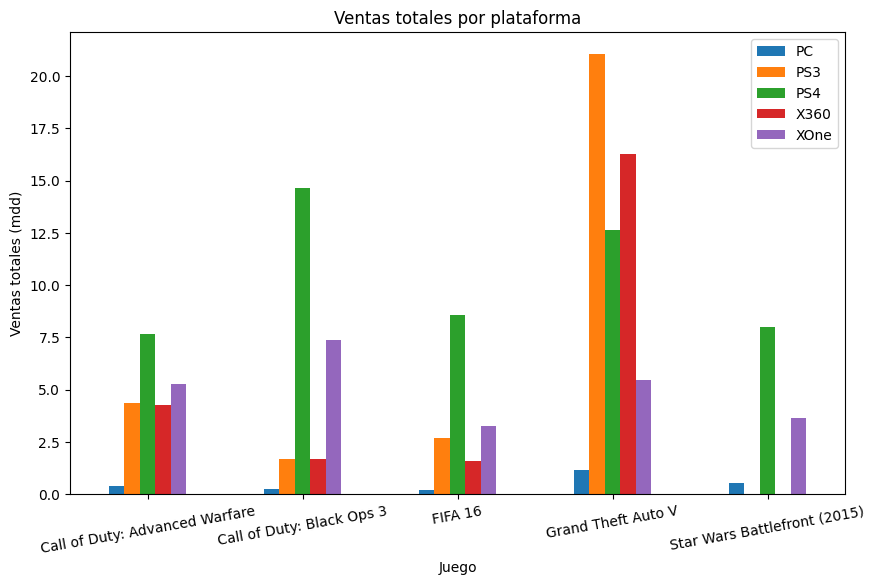

In [31]:
# Creo el grafico
sales_top_5.plot(
    kind = 'bar',
    figsize = (10, 6),
    rot = 10
)

# Personalizo el grafico
plt.title('Ventas totales por plataforma')
plt.xlabel('Juego')
plt.ylabel('Ventas totales (mdd)')
plt.legend()
plt.show()

Con el grafico anterior nos podemos dar cuenta como la generacion anterio (X360 y PS3) dominaron el mercado con un juego masivo como GTAV. Pero con juegos nuevos se comienza a notar el aumento de ventas en las nuevas consolas (PS4 Y XOne). Esto nos dice que todas las campañas de marketing deberan ir enfocadas en las nuevas generaciones, recordemos que anteriormente nos dimos cuenta que X360 Y PS3 comiensan su camino a la obsolescencia.

# 3.7 Un vistazo a la distribución general de los juegos por género.

In [32]:
# Agrupo por genero y ordeno de forma descendente
sales_genre = recent_games.groupby('genre')['total_sales'].sum().sort_values(ascending = False)
sales_genre

genre
Action          1050.59
Shooter          678.80
Sports           658.07
Misc             487.89
Role-Playing     465.03
Racing           265.19
Platform         230.45
Simulation       199.13
Fighting         166.00
Adventure        129.99
Puzzle            79.18
Strategy          68.99
Name: total_sales, dtype: float64

## 3.7.1 ¿Qué se puede decir de los géneros más rentables? ¿Puedes generalizar acerca de los géneros con ventas altas y bajas?


Si, podemos generalizar que existe una gran diferencia entre los generos de "alto presupuesto" y los de "nicho".
1. Ventas altas:
   Los generos lideres son aquellos que se basan en el juego rapido y multijugador.
3. Ventas bajas:
   Los generos de la parte inferior de la lista, son generos mas orientados al pensamiento o simulacion.

# Paso 4. Crea un perfil de usuario para cada región

## 4.1 Las cinco plataformas principales. Describe las variaciones en sus cuotas de mercado de una región a otra.

In [33]:
# Agrupo las ventas de cada plataforma por regiones y calculo su cuota de mercado (venta plataforma / venta global) *100

na_platforms = recent_games.groupby('platform')['na_sales'].sum().sort_values(ascending = False).head(5).rename('Norte America')

# Calculo la cuota de mercado de na

total_na_sales = recent_games['na_sales'].sum()
cuota_na = ((na_platforms / total_na_sales) * 100).reset_index()

In [34]:
eu_platforms = recent_games.groupby('platform')['eu_sales'].sum().sort_values(ascending = False).head(5).rename('Europa')

# Calculo la cuota de mercado de eu

total_eu_sales = recent_games['eu_sales'].sum()
cuota_eu = ((eu_platforms / total_eu_sales) * 100).reset_index()

In [35]:
jp_platforms = recent_games.groupby('platform')['jp_sales'].sum().sort_values(ascending = False).head(5).rename('Japon')

# Calculo la cuota de mercado de jp

total_jp_sales = recent_games['jp_sales'].sum()
cuota_jp = ((jp_platforms / total_jp_sales) * 100).reset_index()

In [36]:
# Hago merge() con todas las cuotas para poder graficar

cuota_global = cuota_na.merge(cuota_eu, on = 'platform', how = 'left')
cuota_global = cuota_global.merge(cuota_jp, on = 'platform', how = 'outer')

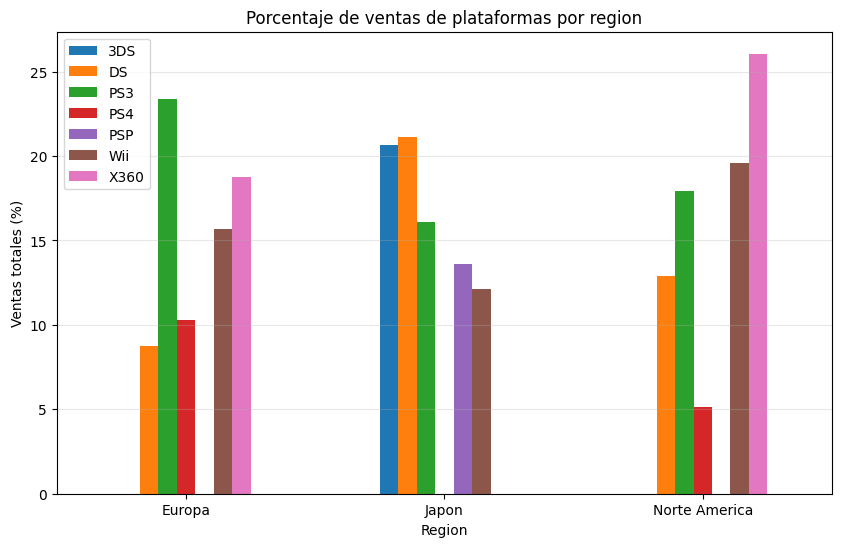

In [37]:
# Hago un pivot_table() para que las plataformas sean columnas y sea mas facil graficar

cuota_global = cuota_global.pivot_table(columns = 'platform')

# creo la grafica de barras

cuota_global.plot(kind = 'bar', figsize = (10, 6), rot = 0)
plt.title('Porcentaje de ventas de plataformas por region')
plt.xlabel('Region')
plt.ylabel('Ventas totales (%)')
plt.legend()
plt.grid(axis = 'y', alpha = 0.3)
plt.show()

Observando el gráfico anterior (sobre el porcentaje que cada plataforma aporta a las ventas totales de cada región):

- `Norteamérica (NA)`: Muestra una preferencia por las consolas de Microsoft/Sony de la generación anterior. La X360 tiene la cuota más alta, seguida por la PS3.

- `Europa (EU)`: Es similar a NA, pero con una cuota ligeramente mayor para PS3 y X360 que la PS4. Esto sugiere una lenta transición hacia la nueva generación.

- `Japón (JP)`: El mercado japonés es único. La cuota está dominada por consolas de Nintendo y portátiles (3DS, DS, PSP), y la PS3 también tiene una presencia fuerte. Las consolas como X360 y XOne tienen una cuota de mercado mínima o nula.

- `El Insight para 2017`: Las campañas publicitarias deben ser localizadas. En Japón, la promoción debe enfocarse en Nintendo/Sony portátil; en NA y EU, la transición a PS4/XOne será la prioridad.

## 4.2 Los cinco géneros principales.

In [38]:
# Agrupo las ventas de cada genero por regiones

na_genre = recent_games.groupby('genre')['na_sales'].sum().sort_values(ascending = False).head(5).rename('Norte_America').reset_index()

eu_genre = recent_games.groupby('genre')['eu_sales'].sum().sort_values(ascending = False).head(5).rename('Europa').reset_index()

jp_genre = recent_games.groupby('genre')['jp_sales'].sum().sort_values(ascending = False).head(5).rename('Japon').reset_index()

In [39]:
# Hago el merge() para posteriormente graficar

genre_global = na_genre.merge(eu_genre, on = 'genre', how = 'outer')
genre_global = genre_global.merge(jp_genre, on = 'genre', how = 'outer')
genre_global

,genre,Norte_America,Europa,Japon
0,Action,492.17,335.67,96.29
1,Shooter,350.11,230.16,NaN
2,Sports,323.86,211.49,40.28
3,Misc,259.16,127.62,48.79
4,Role-Playing,175.41,NaN,150.55
5,Racing,NaN,104.63,NaN
6,Adventure,NaN,NaN,26.91


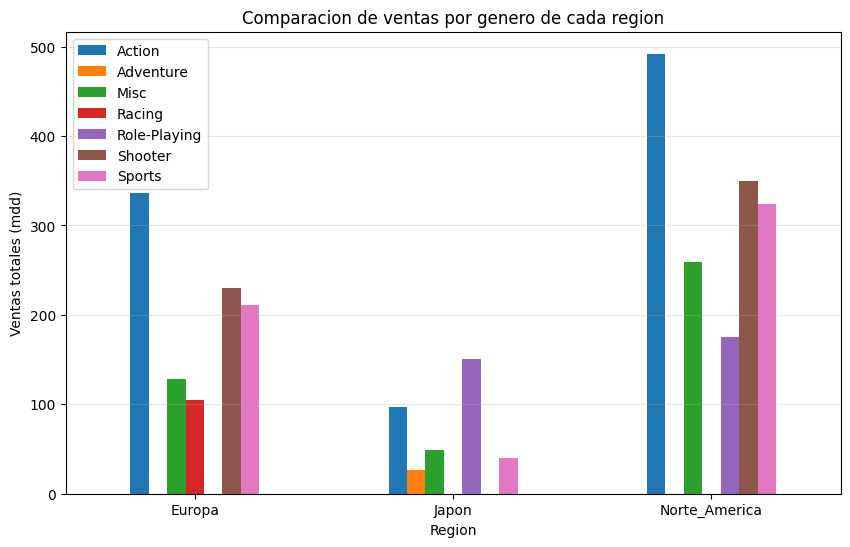

In [40]:
# Hago un pivot_table() para que los generos sean columnas y sea mas facil graficar

genre_global = genre_global.pivot_table(columns = 'genre')

# creo la grafica de barras

genre_global.plot(kind = 'bar', figsize = (10, 6), rot = 0)
plt.title('Comparacion de ventas por genero de cada region')
plt.xlabel('Region')
plt.ylabel('Ventas totales (mdd)')
plt.legend()
plt.grid(axis = 'y', alpha = 0.3)
plt.show()

- `NA y EU`: Ambas regiones muestran a `Action` como el género más rentable, con volúmenes de ventas altísimos. Los géneros con alta demanda son: `Shooter` y `Sports` están en el segundo y tercer puesto en ambas regiones.

- `JP`: El mercado japonés vuelve a ser diferente. El género más vendido es `Role-Playing`, el cual tiene menos ventas en NA/EU, pero es el más rentable en Japon. Géneros como `Shooter` y `Sports` son menos populares en Japón.

- `Insights`: La promoción en Japón debe estar fuertemente enfocada en `Role-Playing`. La publicidad en NA y EU puede tener una estrategia enfocada en los de `acción y deportes`.

## 4.3 Si las clasificaciones de ESRB afectan a las ventas en regiones individuales.

In [41]:
# Agrupare las ventas de cada clasificacion por region

na_rating = recent_games.groupby('rating')['na_sales'].sum().sort_values(ascending = False).head(5).rename('Norte_America').reset_index()

eu_rating = recent_games.groupby('rating')['eu_sales'].sum().sort_values(ascending = False).head(5).rename('Europa').reset_index()

jp_rating = recent_games.groupby('rating')['jp_sales'].sum().sort_values(ascending = False).head(5).rename('Japon').reset_index()

In [42]:
# Hago el merge() para posteriormente graficar

global_rating = na_rating.merge(eu_rating, on = 'rating', how = 'outer')
global_rating = global_rating.merge(jp_rating, on = 'rating', how = 'outer')
global_rating

,rating,Norte_America,Europa,Japon
0,E,663.99,393.08,95.06
1,M,546.55,385.86,41.09
2,T,371.32,217.89,74.74
3,E10+,287.61,162.75,31.91
4,EC,1.32,NaN,0.00
5,RP,NaN,0.03,NaN


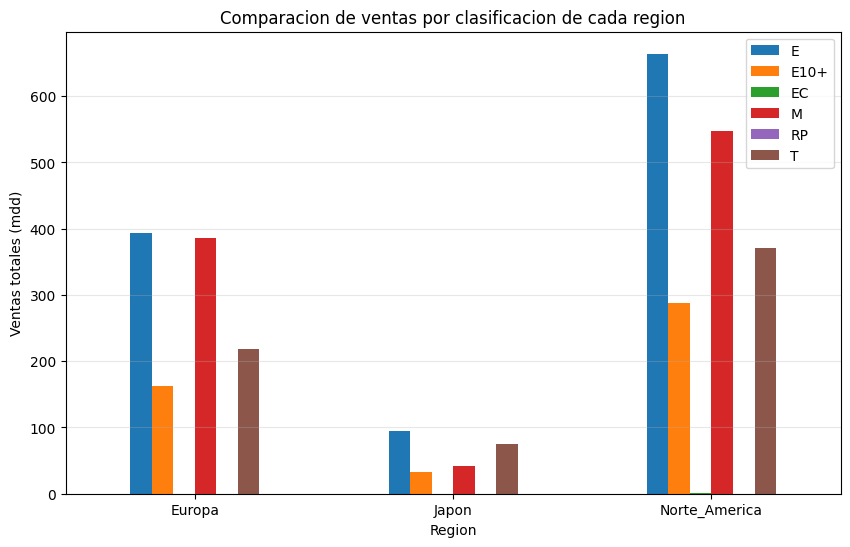

In [43]:
# Hago un pivot_table() para que el rating sea las columnas

global_rating = global_rating.pivot_table(columns = 'rating')

# creo la grafica de barras

global_rating.plot(kind = 'bar', figsize = (10, 6), rot = 0)
plt.title('Comparacion de ventas por clasificacion de cada region')
plt.xlabel('Region')
plt.ylabel('Ventas totales (mdd)')
plt.legend()
plt.grid(axis = 'y', alpha = 0.3)
plt.show()

`E	Everyone (Todos)`	6+ años

`E10+	Everyone`	10+ años

`EC (Early Childhood / Niños Pequeños)`

`M	Mature` 17+ años

`RP (Rating Pending / Clasificación Pendiente)`

`T	Teen (Adolescentes)`	13+ años

### ¿Las clasificaciones de ESRB afectan a las ventas en regiones individuales?

La respuesta es un sí, las clasificaciones afectan dramáticamente las ventas por región.


- `NA`: La clasificación más vendida es `E (Everyone)`, seguida muy de cerca por `M (Mature)`.

- `EU`: Europa muestra un patrón muy similar a NA, con `E (Everyone) y M (Mature)` como los líderes en ventas.

- `JP`: El volumen de ventas total de Japón es mucho menor en comparación con NA y EU (lo cual ya vimos en los géneros). El género más vendido es `E (Everyone)`. Sin embargo, en contraste con Occidente, el rating `M (Mature)` tiene un volumen de ventas significativamente más bajo. La clasificación `T (Teen)` (no visible por separado en tu gráfico, pero sí en tu tabla de datos) suele ser relativamente más importante aquí que los juegos M.

- `Insights`: 
    1. Esto indica que el mercado norteamericano tiene dos frentes: juegos familiares/casuales y blockbusters de acción madura (como Call of Duty o Grand Theft Auto).
    2. La estrategia en EU puede imitar a NA, con inversión en juegos maduros.
    3. La campaña en Japón debe evitar enfocarse en juegos clasificados como M y debe priorizar juegos con clasificación E o T.

# Paso 5. Prueba las siguientes hipótesis

## 5.1 Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

### Hipotesis Nula ($H_0$)
La $H_0$ siempre dice que `NO` hay diferencia, me refiero a que siempre será $=$. Por lo tanto:

$H_0$ : `Las clasificaciones promedio de los usuarios de XOne y PC son las mismas.`
### Hipotesis Alternativa ($H_1$)
La $H_1$ dice que `SI` hay diferencia $\neq$. Por lo tanto:

$H_1$ : `Las clasificaciones promedio de los usuarios de XOne y PC son diferentes.`

## 5.1.1 Preparo los datos para la prueba

In [53]:
# Primero verifico si hay valores NaN que puedan afectar la prueba

recent_games['user_score'].isnull().sum()

4924

In [54]:
# Filtro los valores NaN
clean_games = recent_games[~recent_games['user_score'].isnull()]
clean_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
13,Wii Fit,Wii,2007,Sports,8.92,8.03,3.60,2.15,80.0,7.7,E,22.70
14,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61.0,6.3,E,21.82


In [55]:
# Ahora agrupo las puntuaciones de usuario por plataforma
score_xone = clean_games[clean_games['platform'] == 'XOne']['user_score']
score_pc = clean_games[clean_games['platform'] == 'PC']['user_score']

`Utilizare una prueba t para dos muestras independientes`
- Primero calculare la varianza de ambas muestras para determinar si usar True/False en `equal_var`

In [56]:
var_xone = score_xone.var() 
var_pc = score_pc.var()

print(var_xone)
print(var_pc)

1.9069968429360695
2.3403339171044952


Vemos que las varianzas no son iguales asi que procedo a utilizar `equal_var = False` en la prueba t

Defino $\alpha$ con 0.05 

In [57]:
alpha = 0.05

t_stat, p_value = stats.ttest_ind(score_xone, score_pc, equal_var = False)

print('valor p:', p_value)

if (p_value < alpha):
    print("Rechazamos la hipotesis nula")
else:
    print("No podemos rechazar la hipotesis nula")

valor p: 0.04401892858926167
Rechazamos la hipotesis nula


Existe suficiente evidencia para concluir que `SI` hay una diferencia en las puntuaciones promedio de los usuarios entre los juegos de Xbox One y los juegos de PC.

## 5.2 Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

$H_0$ : Las calificaciones promedio de los usuarios para los generos de Accion y Deportes son iguales.

$H_1$ : Las calificaciones promedio de los usuarios para los generos de Accion y Deportes son diferentes.

## 5.2.1 Preparo los datos para la prueba

In [58]:
# Obtengo los nombres excactos de los generos

clean_games['genre'].unique()

array(['Racing', 'Sports', 'Platform', 'Misc', 'Action', 'Shooter',
       'Fighting', 'Simulation', 'Role-Playing', 'Adventure', 'Puzzle',
       'Strategy'], dtype=object)

In [59]:
# Aislo ambas Series

score_action = clean_games[clean_games['genre'] == 'Action']['user_score']
score_sports = clean_games[clean_games['genre'] == 'Sports']['user_score']

In [60]:
# Verifico sus varianzas

var_action = score_action.var()
var_sports = score_sports.var()

print(var_action)
print(var_sports)

1.830189395225529
2.814034856727071


De nuevo aplicare una prueba t para dos muestras independientes con equal_var = False

In [61]:
t_stat, p_value = stats.ttest_ind(score_action, score_sports, equal_var = False)

print('valor p:', p_value)

if (p_value < alpha):
    print("Rechazamos la hipotesis nula")
else:
    print("No podemos rechazar la hipotesis nula")

valor p: 4.540665510055229e-11
Rechazamos la hipotesis nula


El valor p es extremadamente pequeño (cercano a cero), significa que podemos concluir que `SI` existe una diferencia en las puntuaciones promedio de los usuarios entre los juegos de genero accion y deportes.

# Paso 6. Conclusion general

La estrategia publicitaria debe ser enfocada en la generación actual, ignorando las plataformas en fase de obsolescencia (PS2, X360, PS3).

- `Principal plataforma`: PS4. Muestra las mejores ventas de títulos multiplataforma en la generación actual, superando a Xbox One.
- `Principales Regiones`: Norteamérica y Europa. Ambas regiones consumen gran cantidad de juegos, el consumo de plataformas y géneros son muy similares entre si.
- `Región de Nicho`: Japón. Es un mercado unico, dominado por consolas portátiles y juegos Role-Playing.


- `Géneros más Rentables`: La inversión debe centrarse en los géneros de alto impacto: Action (el más rentable), Shooter y Sports.
- `Clasificación ESRB`: Las ventas más altas en NA y EU se dan en las clasificaciones E (Everyone) y M (Mature). La campaña debe dirigirse a juegos con clasificacion M.


- `Impacto de las Reseñas`: El factor que mejor predice las ventas iniciales es la Crítica Profesional.
    - `Crítico (Puntuación vs. Ventas):` Existe una correlación positiva, lo que indica que las buenas reseñas de críticos `SI` impulsan las ventas.
    - `Usuario (Puntuación vs. Ventas):` Existe una correlación casi en 0, significa que la opinion del usuario no influye en el volumen de ventas total ya que esta viene despues de la compra.

La campaña publicitaria debe buscar buenas reseñas de críticos.

- `Puntuaciones de Usuarios`
    - `XOne vs. PC:` Hay una diferencia en cómo los usuarios califican los juegos en XOne con los de PC. Esto requiere que el equipo de marketing haga campañas por plataformas separadas.
    - `Action vs. Sports:` Hay una diferencia en las puntuaciones promedio para juegos de Acción y Deportes.

`Conclusion Final para 2017`

El enfoque para 2017 debe ser invertir en campañas para las consolas de nueva generación (PS4 como la mas rentable) en los mercados de NA y EU con juegos de Acción, Shooter o Sports con buenas reseñas de los crítico.